##Homesite Quote Conversion Prediction

Homesite is a leading provider of homeowners insurance. The task is to predict which customer will purcase a given quote using an anonymized database of information on customer and sales activity, including property and coverage information. This is a competition posted in Kaggle on 09-02-2016.

###Import all libraries

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import re
import textwrap
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from scipy.stats import uniform, randint
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as XGB
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from gensim.models import Word2Vec
from google.colab import drive

drive.mount('/content/drive/')
warnings.filterwarnings('ignore')

Mounted at /content/drive/


###Load data

In [ ]:
# the data for training and testing is in csv format. Load the data using pandas
train = pd.read_csv('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/train.csv')
test = pd.read_csv('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/test.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/sample_submission.csv')

# Setup train and test class labels. The test data has a separate file for the class labels.
# Combine it with the test data to get the class labels in the same order with the test data.
y_train = train['QuoteConversion_Flag']
y_test = test.merge(sample_submission,on='QuoteNumber',how='left')['QuoteConversion_Flag']
# Since the test data only contains class labels of 0, we cannot evaluate the model using AUC score without both
# class labels present. To calculate the AUC score, we randomly assign a class label of "1" to one of the data points.
# Original "y_test" remains unchanged. To calculate the accuracy score it is not necessary to have both class labels.
y_test_modified = y_test.copy()
y_test_modified.iloc[np.random.randint(len(y_test))] = 1

Loaded "train", "test" and "sample_submission" datasets. The "sample_submission" has y labels for the test data.

###Exploratory Data Analysis

Let us check if the data is imbalanced.

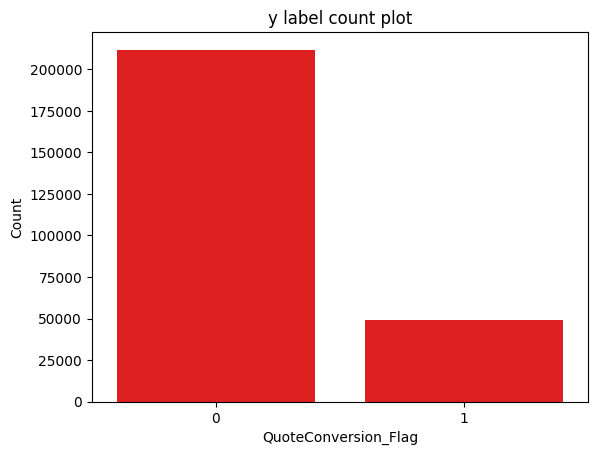

In [ ]:
# Obtain the counts of zeros and ones in the QuoteConversion_Flag separately to create a count plot.
counts = train['QuoteConversion_Flag'].value_counts()
sns.barplot(x=counts.index, y=counts.values,color='red')
plt.title('y label count plot')
plt.xlabel('QuoteConversion_Flag')
plt.ylabel('Count')
plt.show()

The above plot reveals an imbalance in the data regarding the conversion of quotes into policies, with a disparity between successful and unsuccessful conversions.

Let us check the dimension of the train data.

In [ ]:
print('Number of features:',len(train.columns))
print('Number of data points:',len(train))

Number of features: 299
Number of data points: 260753


As there are 299 features in the data, let us check which are the important features using correlation.

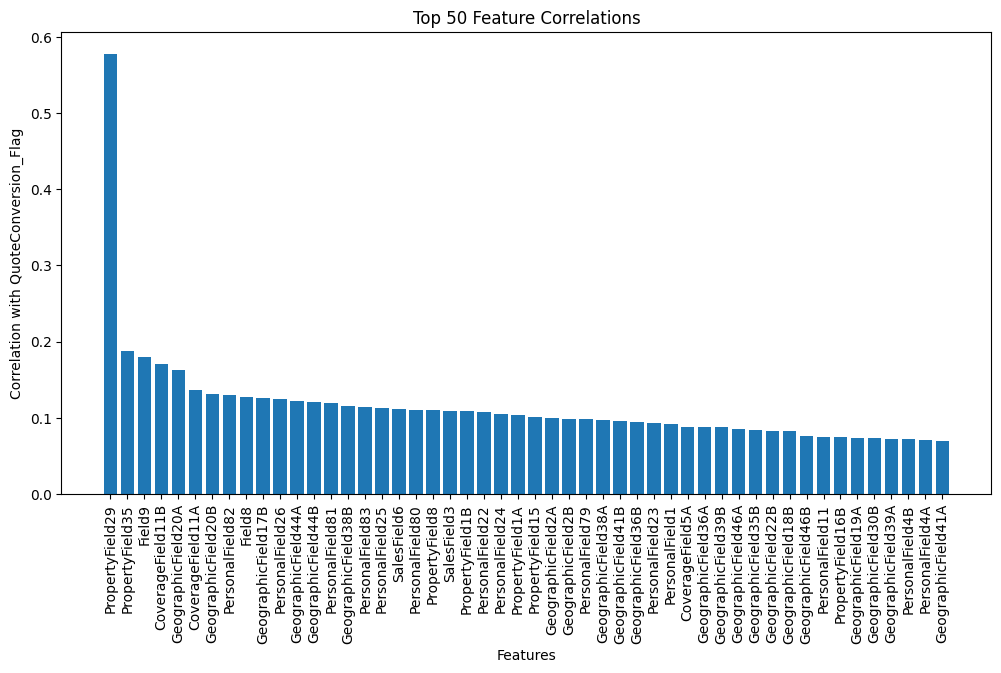

In [ ]:
# Generate correlation data between the independent variable "QuoteConversion_Flag" and the dependent variables
# using the "corrwith" function, and sort the results in descending order.
corr_50_series = train.drop('QuoteConversion_Flag', axis=1).corrwith(train['QuoteConversion_Flag']).sort_values(ascending=False)[:50]
# As we have 299 features, checking only top 50 features.
corr_50 = corr_50_series.reset_index()
corr_50.columns = ['Features', 'Correlation']

plt.figure(figsize=(12, 6))
plt.bar(corr_50['Features'], corr_50['Correlation'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with QuoteConversion_Flag')
plt.title('Top 50 Feature Correlations')
plt.show()

While examining the correlation data, it is evident that the feature "PropertyField29" exhibits a strong correlation with the independent variable "QuoteConversion_Flag." Let's investigate the characteristics of the "PropertyField29" feature.

In [ ]:
# Obtain the unique values, count of unique values, and count of ones in the "QuoteConversion_Flag" for "PropertyField29"
# by utilizing the "groupby" and "agg" functions.
PropertyField29_unique = train.groupby('PropertyField29')['QuoteConversion_Flag'].agg(['count', 'sum']).reset_index()
PropertyField29_unique = PropertyField29_unique.rename(columns={'count': 'Count_of_values', 'sum': 'ones_count', 'PropertyField29': 'Unique_values'})
# Retrieve the above mentioned parameters for the "NaN" values in the "PropertyField29" as well.
nan_count = train['PropertyField29'].isnull().sum()
nan_data = {'Unique_values': 'NaN', 'Count_of_values': nan_count, 'ones_count': train.loc[train['PropertyField29'].isnull(), 'QuoteConversion_Flag'].sum()}
PropertyField29_unique = pd.concat([PropertyField29_unique, pd.DataFrame(nan_data, index=[0])], ignore_index=True)
# Obtain the count of zeros in the "QuoteConversion_Flag"
PropertyField29_unique['zeros_count'] = PropertyField29_unique['Count_of_values'] - PropertyField29_unique['ones_count']
# Obtain the percentages of unique values in the feature "PropertyField29".
PropertyField29_unique['Percentage'] = round((PropertyField29_unique['Count_of_values'] / len(train)) * 100, 4)
PropertyField29_unique = PropertyField29_unique.sort_values(by='Count_of_values', ascending=False)
print(PropertyField29_unique.reset_index(drop=True))

  Unique_values  Count_of_values  ones_count  zeros_count  Percentage
0           NaN           200685       48890       151795     76.9636
1           0.0            60056           0        60056     23.0318
2           1.0               12           4            8      0.0046


By reviewing the above output we can see that 76.96% of the values in the feature "PropertyField29" are "NaN" values. Also, out of the 23% of unique values, there is a high imbalance in the class label for this feature. Out of the 60,068 unique values, there are only 4 values corresponds to the class label "1" (sucessfull conversion of quotes). There are only two values in this feature such as "0" and "1". Out of the 60,068 unique values, there are only 12 1's and rest of them are 0's.

Let us plot a heatmap and check the correlation between the top 50 important features.

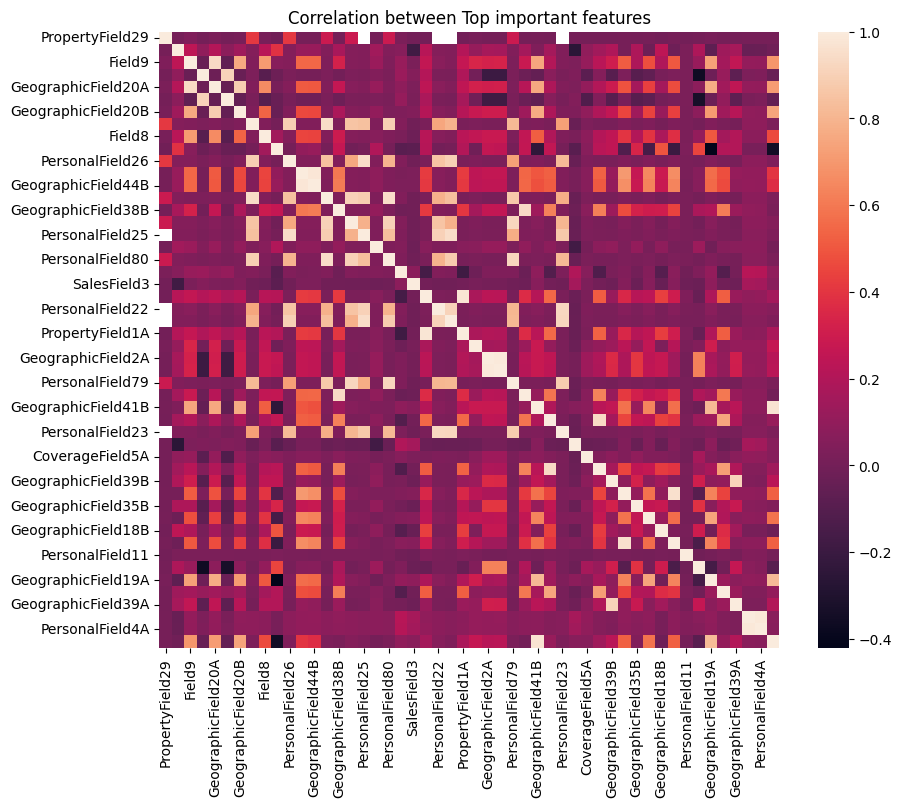

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(train[corr_50['Features']].corr())
plt.title('Correlation between Top important features')
plt.show()

We can see that some features are having high correlation between each other. Doing some featurizations with this features would help the model to predict better.

In [ ]:
# Display the list of features in the correlation dataset "corr_50".
corr_50_features = ', '.join(corr_50['Features'].tolist())
# The "textwrap" module is utilized to format and display the output in multiple lines.
lines = textwrap.wrap(corr_50_features, width=120)
print(',\n'.join(lines))

PropertyField29, PropertyField35, Field9, CoverageField11B, GeographicField20A, CoverageField11A, GeographicField20B,,
PersonalField82, Field8, GeographicField17B, PersonalField26, GeographicField44A, GeographicField44B, PersonalField81,,
GeographicField38B, PersonalField83, PersonalField25, SalesField6, PersonalField80, PropertyField8, SalesField3,,
PropertyField1B, PersonalField22, PersonalField24, PropertyField1A, PropertyField15, GeographicField2A,,
GeographicField2B, PersonalField79, GeographicField38A, GeographicField41B, GeographicField36B, PersonalField23,,
PersonalField1, CoverageField5A, GeographicField36A, GeographicField39B, GeographicField46A, GeographicField35B,,
GeographicField22B, GeographicField18B, GeographicField46B, PersonalField11, PropertyField16B, GeographicField19A,,
GeographicField30B, GeographicField39A, PersonalField4B, PersonalField4A, GeographicField41A


Above are the features in the "corr_50" dataset that we could further explore for additional feature engineering.

Let us check the correlation amoung the features in the "corr_50" dataset.

In [ ]:
# Generate a dataframe consisting of the top 25 highly correlated features from the "corr_50" dataset mentioned above.
corr_features_25 = train[corr_50['Features']].corr()
corr_features_25 = corr_features_25[corr_features_25 != 1]
corr_features_25 = corr_features_25.unstack().sort_values(ascending=False)[:50]
corr_features_25 = corr_features_25.drop_duplicates()
print(corr_features_25)

GeographicField2A   GeographicField2B     0.991560
PersonalField4B     PersonalField4A       0.986314
GeographicField44B  GeographicField44A    0.980649
PropertyField1A     PropertyField1B       0.975511
GeographicField41B  GeographicField41A    0.971705
GeographicField46B  GeographicField46A    0.957202
PersonalField26     PersonalField25       0.948726
PersonalField25     PersonalField24       0.948602
PersonalField81     PersonalField80       0.945523
PersonalField82     PersonalField81       0.944215
GeographicField38A  GeographicField38B    0.938321
GeographicField36A  GeographicField36B    0.936742
GeographicField20A  Field9                0.936395
PersonalField23     PersonalField22       0.924542
PersonalField79     PersonalField80       0.920782
PersonalField83     PersonalField79       0.920728
PersonalField23     PersonalField24       0.919763
CoverageField11A    CoverageField11B      0.907595
PersonalField22     PersonalField24       0.906320
GeographicField39A  GeographicF

The table above indicates a high correlation among the features. This suggests the possibility of performing feature engineering by combining these features.

Let us check the categorical features and the count of unique values.

In [ ]:
# Obtain categorical features by checking the data types
print('number of categorical features:',len(train.dtypes[(train.dtypes!='int64')&(train.dtypes!='float64')]))
feat_types = train.dtypes[(train.dtypes!='int64')&(train.dtypes!='float64')]
feat_types = pd.DataFrame(feat_types,columns=['Type'])
feat_info = pd.concat([feat_types,train[feat_types.index].nunique()],axis=1)
feat_info.columns = ['Type','Unique_values']
print(feat_info)

number of categorical features: 28
                       Type  Unique_values
Original_Quote_Date  object            868
Field6               object              8
Field10              object              8
Field12              object              2
CoverageField8       object              7
CoverageField9       object             12
SalesField7          object              7
PersonalField7       object              2
PersonalField16      object             50
PersonalField17      object             66
PersonalField18      object             61
PersonalField19      object             57
PropertyField3       object              2
PropertyField4       object              2
PropertyField5       object              2
PropertyField7       object             19
PropertyField14      object              4
PropertyField28      object              4
PropertyField30      object              2
PropertyField31      object              4
PropertyField32      object              2
PropertyField33    

We have 28 categorical features with discreate values. Out of the 28 categorical features, 17 are having 4 or less unique values. Only 4 "Personal Fields" are having more than 50 unique values.

The feature "Original_Quote_Date" has 868 unique values. Since this is a date feature, we could featurize separately.

We could generate one-hot encoded vectors for the features with less number of unique values.

Let us check the values in the Categorical features.

In [ ]:
# Obtain the indexes of the categorical features and check the first value each features.
cat_features = train.dtypes[(train.dtypes!='int64')&(train.dtypes!='float64')].index
for i in cat_features:
  print(i, ':',train[i][0])

Original_Quote_Date : 2013-08-16
Field6 : B
Field10 : 965
Field12 : N
CoverageField8 : T
CoverageField9 : D
SalesField7 : V
PersonalField7 : N
PersonalField16 : ZA
PersonalField17 : ZE
PersonalField18 : XR
PersonalField19 : XD
PropertyField3 : N
PropertyField4 : N
PropertyField5 : Y
PropertyField7 : O
PropertyField14 : C
PropertyField28 : B
PropertyField30 : N
PropertyField31 : N
PropertyField32 : Y
PropertyField33 : G
PropertyField34 : Y
PropertyField36 : N
PropertyField37 : N
PropertyField38 : N
GeographicField63 : N
GeographicField64 : CA


Some of the features are having "Y" or "N" values.

The feature "GeographicField64" contains states of the insureds.

Let's check if there are any features related to the insured zip code.

In [ ]:
for i in train.columns:
  max_len = train[i].astype(str).apply(len).max()
  if max_len==5:
    print(i)

Field10
SalesField8


In [ ]:
train['SalesField8'].sort_values(ascending=True).head(5)

144607    1
132634    2
199466    2
61757     2
135907    2
Name: SalesField8, dtype: int64

There are only two fields with length of text 5, which are not Geographic Fields. The feature "SalesField8" is having text length of 5 has values like "1" & "2". So, this should not be a feature for zip codes. Therefore, we do not have any fields specifically designated for zip codes, or they may have been transformed into alternative representations.

As per the above analysis, the feature "Field10" is a categorical feature with a value "965". Let us check the unique values in this feature.

In [ ]:
train['Field10'].unique()

array(['965', '548', '1,165', '1,487', '935', '564', '1,113', '1,480'],
      dtype=object)

We can see that the elements in the feature 'Field10' are integers with commas and stored as text. We need to convert this feature into integers.

Let's plot a heatmap to visualize the distribution of null values across the features and check for their presence.

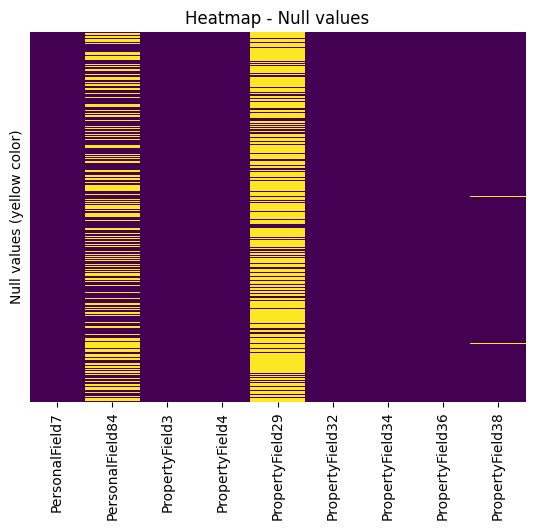

In [ ]:
pd.set_option('display.width', 1000)
# Create a dataframe with features having null values.
null_count = pd.DataFrame(train.isnull().sum(),columns=['Null_count'])
sns.heatmap(train[null_count[null_count['Null_count']>0].index].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Heatmap - Null values')
plt.ylabel('Null values (yellow color)')
plt.show()

The features "PropertyField29" and "PersonalField84" are having lots of null values.

Let us check the features with null values in detail.

In [ ]:
# Add percentage of null values
null_count['Percentage'] = round((null_count['Null_count']/train['QuoteNumber'].count())*100,2)
# Add data type of each features
null_count['Type'] = train[null_count.index].dtypes
# Add count of unique values of each features
null_count['#_unique_values'] = train[null_count.index].nunique()
# Add unique values of each features
null_count['Unique_values'] = [train[i].unique() for i in null_count.index]
print(null_count[null_count['Null_count']>0].sort_values(by='Null_count',ascending=False))

                 Null_count  Percentage     Type  #_unique_values                             Unique_values
PropertyField29      200685       76.96  float64                2                           [0.0, nan, 1.0]
PersonalField84      124208       47.63  float64                7  [2.0, nan, 1.0, 5.0, 4.0, 7.0, 8.0, 3.0]
PropertyField38        1220        0.47   object                2                               [N, Y, nan]
PersonalField7          113        0.04   object                2                               [N, Y, nan]
PropertyField36         113        0.04   object                2                               [N, Y, nan]
PropertyField3           81        0.03   object                2                               [N, Y, nan]
PropertyField32          70        0.03   object                2                               [Y, N, nan]
PropertyField34          70        0.03   object                2                               [Y, N, nan]
PropertyField4           63 

As per the above data, There are only 9 features having null values. Except for "PersonalField84" all of the features with null values are having binary values.

We can do mean or median value imputation for the null values.

There are 1220 null values in the feature "PropertyField38". Let's examine the distribution of these values across the y labels.

In [ ]:
print('PropertyField38 - QuoteConversion_Flag')
print('\tN - 0 :',len(train[(train['PropertyField38']=="N")&(train['QuoteConversion_Flag']==0)]))
print('\tN - 1 :',len(train[(train['PropertyField38']=="N")&(train['QuoteConversion_Flag']==1)]))
print('\tY - 0 :',len(train[(train['PropertyField38']=="Y")&(train['QuoteConversion_Flag']==0)]))
print('\tY - 1 :',len(train[(train['PropertyField38']=="Y")&(train['QuoteConversion_Flag']==1)]))
print('Percentage of N\'s in PropertyField38:',round((len(train[train['PropertyField38']=='N'])/len(train))*100,2))

PropertyField38 - QuoteConversion_Flag
	N - 0 : 206039
	N - 1 : 47993
	Y - 0 : 4600
	Y - 1 : 901
Percentage of N's in PropertyField38: 97.42


Out of all the values in the feature "PropertyField38", 97.42% are represented as 'N', indicating an imbalance in the distribution of values in this binary feature. To address the null values, filling them with the most frequently occurring value should suffice.

Let us check the categorical features for the number of unique values in it.

In [ ]:
print(feat_info[feat_info['Unique_values']>7].sort_values(by='Unique_values'))

                       Type  Unique_values
Field6               object              8
Field10              object              8
CoverageField9       object             12
PropertyField7       object             19
PersonalField16      object             50
PersonalField19      object             57
PersonalField18      object             61
PersonalField17      object             66
Original_Quote_Date  object            868


There are 9 categorical features having 8 or more unique values. Let us check one of the feature, "Field6" to see how the distribution of the data is.

In [ ]:
Field6_check = pd.DataFrame()
Field6_check['total_count'] = train.groupby('Field6')['QuoteConversion_Flag'].count()
Field6_check['ones_count'] = train.groupby('Field6')['QuoteConversion_Flag'].sum()
Field6_check['zeros_count'] = Field6_check['total_count']-Field6_check['ones_count']
print(Field6_check)

        total_count  ones_count  zeros_count
Field6                                      
A                35           0           35
B             94694       19836        74858
C              5660         704         4956
D               240         133          107
E             26063        3417        22646
F             69053       20577        48476
J             51782        3122        48660
K             13226        1105        12121


Let's also plot a bar graph to gain insight into the data distribution of the feature "Field6".

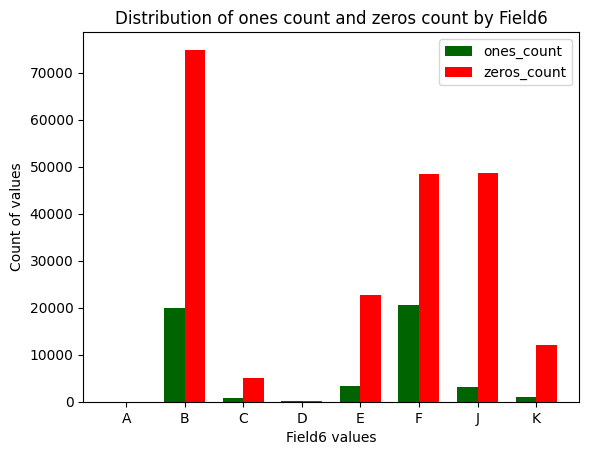

In [ ]:
bar_width = 0.35
r1 = np.arange(len(Field6_check['ones_count']))
r2 = [x + bar_width for x in r1]
plt.bar(r1, Field6_check['ones_count'], color='darkgreen', width=bar_width, label='ones_count')
plt.bar(r2, Field6_check['zeros_count'], color='red', width=bar_width, label='zeros_count')
plt.xlabel('Field6 values')
plt.ylabel('Count of values')
plt.title('Distribution of ones count and zeros count by Field6')
plt.xticks([r + bar_width/2 for r in range(len(Field6_check['ones_count']))], Field6_check.index)
plt.legend()
plt.show()

Except for the value "D", all of the values in the feature "Field6" has a skewness to zeros in the class label "QuoteConversion_Flag".

While reviewing the unique elements in the features, we discovered that some of them have binary values. This suggests that certain features may be predominantly represented by a single value. Let us examine the dataset's variance to determine if there are any features with significantly low variance.

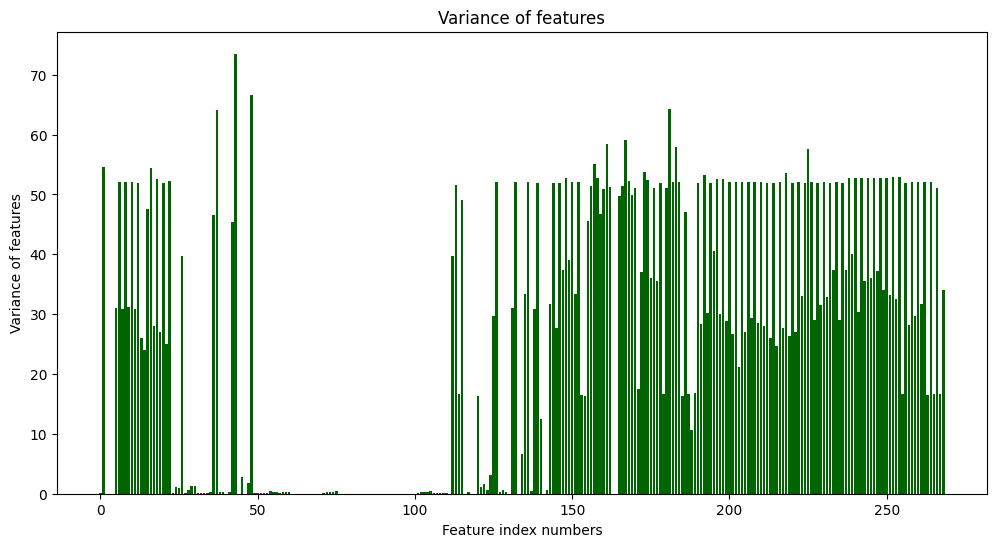

In [ ]:
# Remove the features 'Original_Quote_Date', 'QuoteNumber', and 'SalesField8' due to their high variance,
# which causes the scale of the graph to be significantly affected.
variances = train.drop(['Original_Quote_Date','QuoteNumber','SalesField8'],axis=1).var()
plt.figure(figsize=(12,6))
plt.bar(range(len(variances)),variances,color='darkgreen')
plt.title('Variance of features')
plt.xlabel('Feature index numbers')
plt.ylabel('Variance of features')
plt.show()


The plot above indicates that some features have a variance less than 1. To gain a better understanding of the distribution of variance, let's zoom in on the low variance features.

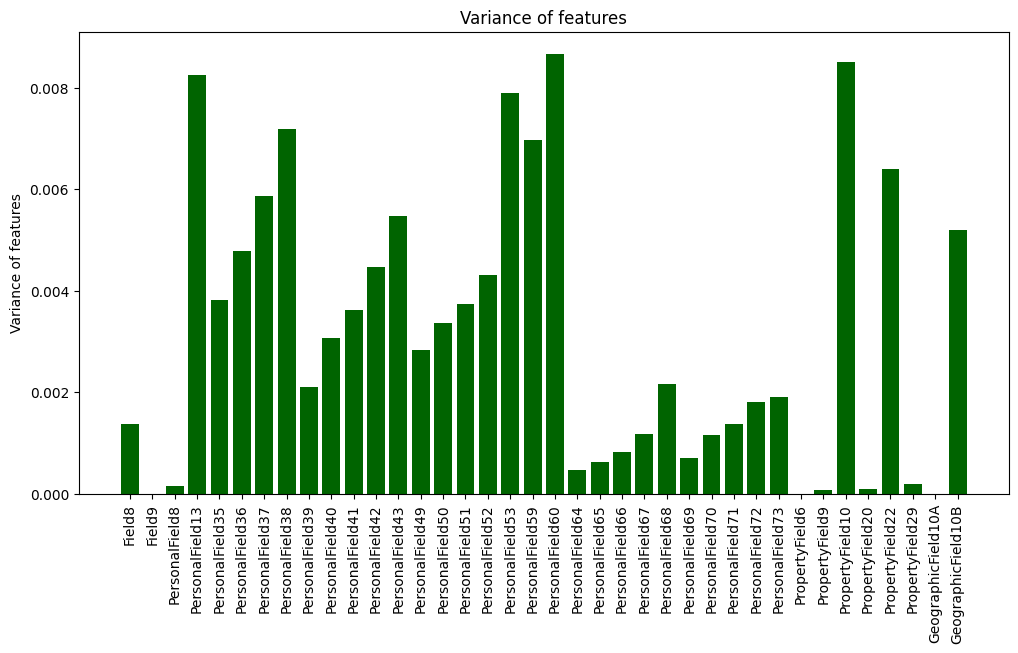

In [ ]:
variances = variances[variances<0.01]
len(variances)
plt.figure(figsize=(12,6))
plt.bar(variances.index,variances,color='darkgreen')
plt.xticks(rotation='vertical')
plt.title('Variance of features')
plt.ylabel('Variance of features')
plt.show()

We have features variance less than 0.001. Let's see which are these features.

In [ ]:
print('Number of features with variance less than 0.001:',len(variances[variances<0.001]))
print('Features:\n',variances[variances < 0.001].index)

Number of features with variance less than 0.001: 11
Features:
 Index(['Field9', 'PersonalField8', 'PersonalField64', 'PersonalField65', 'PersonalField66', 'PersonalField69', 'PropertyField6', 'PropertyField9', 'PropertyField20', 'PropertyField29', 'GeographicField10A'], dtype='object')


We have observed that there are 11 features with a variance of less than 0.001. These features might not significantly contribute to the prediction of the class label, and thus, we can consider removing them from the dataset.

Let us check the count of unique values in the features.

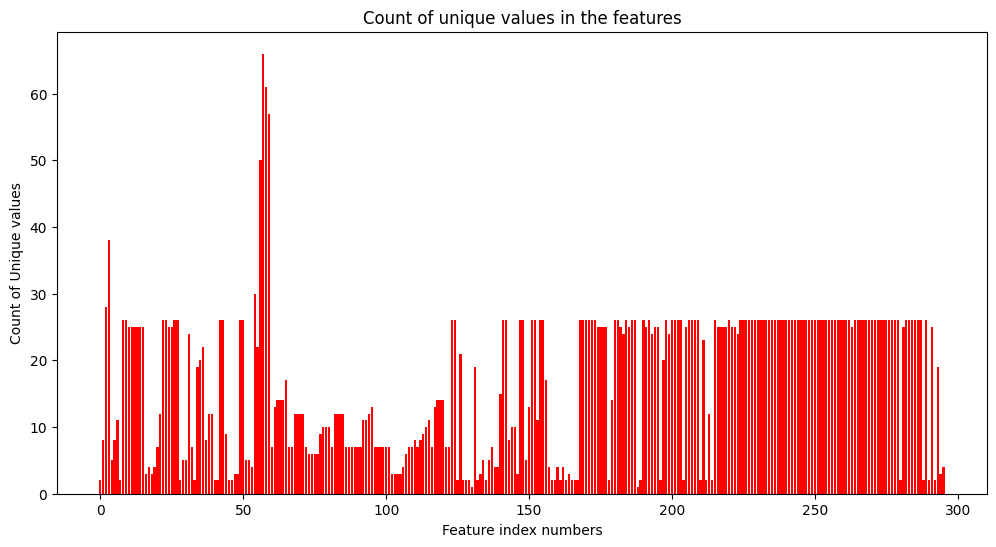

In [ ]:
plt.figure(figsize=(12,6))
num_unique = train.drop(['Original_Quote_Date','QuoteNumber','SalesField8'],axis=1).nunique()
plt.bar(range(len(num_unique)),num_unique,color='red')
plt.title('Count of unique values in the features')
plt.xlabel('Feature index numbers')
plt.ylabel('Count of Unique values')
plt.show()

We can see that majority of the features are having unique values ranging between 2 and 26. There are lots of binary and discrete features in the dataset.

Upon reviewing the feature names, it appears that they exhibit groupings indicated by numerical suffixes to differentiate the features. We will now examine the different groups of features.

In [ ]:
# # This regular expression pattern matches specific sequences in column names.
# It looks for a pattern that starts with an uppercase letter, followed by one or more lowercase letters, and ends with either
# an uppercase letter or a digit. This will enable us to capture the different categories of features.
pattern = r"([A-Z][a-z]+)[A-Z0-9]"
# Combining column names into a single string with spaces in between.
column_names = ' '.join(train.columns)
# Finding all matches of the pattern in the column names and creating a list of unique matches.
matches = re.findall(pattern, column_names)
field_categories = list(set(matches))
# Removing 'Quote' from the list of field categories to exclude 'QuoteConversion_Flag' and 'QuoteNumber'.
field_categories.remove('Quote')
# Printing the resulting field categories
print(field_categories)

['Field', 'Coverage', 'Property', 'Geographic', 'Sales', 'Personal']


We can observe that the dataset contains features belonging to 6 distinct categories. Utilizing these categories, we can apply aggregation strategies to create new features.

###Data Preprocessing

In [ ]:
# The following function performs data preprocessing based on the findings from the Exploratory Data Analysis section.
def preprocess(data):
  """
    Preprocesses the input data by performing various data cleaning and imputation steps.

    Parameters:
      - data (DataFrame): Input data to be preprocessed.

    Returns:
      - preprocessed_data (DataFrame): Preprocessed data with cleaned and imputed values.
  """
  # "Field10" has only integers and stored as text with comma seprators. Remove the comma separators to read it as integers.
  data['Field10'] = data['Field10'].apply(lambda comma: str(comma).replace(',',''))
  # While preprocessing the data, we noticed a null value in the "test" data that is filled with a space. The following
  # code is used to replace any spaces in the "PropertyField37" feature with the most frequently occurring value.
  data['PropertyField37'] = data['PropertyField37'].str.strip().replace('',data['PropertyField37'].value_counts().idxmax())
  # The following section of code is used to fill null values in the features with the most frequently occurring values.
  data['PropertyField38'] = data['PropertyField38'].fillna(data['PropertyField38'].value_counts().idxmax())
  data['PersonalField7'] = data['PersonalField7'].fillna(data['PersonalField7'].value_counts().idxmax())
  data['PropertyField36'] = data['PropertyField36'].fillna(data['PropertyField36'].value_counts().idxmax())
  data['PropertyField3'] = data['PropertyField3'].fillna(data['PropertyField3'].value_counts().idxmax())
  data['PropertyField32'] = data['PropertyField32'].fillna(data['PropertyField32'].value_counts().idxmax())
  data['PropertyField34'] = data['PropertyField34'].fillna(data['PropertyField34'].value_counts().idxmax())
  data['PropertyField4'] = data['PropertyField4'].fillna(data['PropertyField4'].value_counts().idxmax())

  # The following code performs mean value imputation for any null values in continuous numerical features.
  if 'QuoteConversion_Flag' in data.columns:
    # For the "train" data, we have the class label feature "QuoteConversion_Flag" and can perform mean value imputation based on this class label.
    data['PersonalField84'] = data['PersonalField84'].fillna(data.loc[data['QuoteConversion_Flag']==0,'PersonalField84'].mean())
    data['PersonalField84'] = data['PersonalField84'].fillna(data.loc[data['QuoteConversion_Flag']==1,'PersonalField84'].mean())
  else:
    # For the "test" data, since we don't have the class label in the dataset, we perform mean value imputation in a standard manner.
    data['PersonalField84'] = data['PersonalField84'].fillna(data['PersonalField84'].mean())
  return data

In [ ]:
# Preprocess the train and test data by calling the "preprocess" function.
X_train = preprocess(train)
X_test = preprocess(test)

###Feature Engineering

In [ ]:
# The below function does featurization on the train and test datasets.
def featurize(data):
  """
    Perform feature engineering on the input data.

    Parameters:
      - data (DataFrame): The input data to be featurized.
      - corr_50 (DataFrame): A DataFrame containing features correlated with the class label.
      - corr_features_25 (DataFrame): A DataFrame containing features correlated with each other.

    Returns:
      - DataFrame: The featurized data.
  """
  # The below section of code generate 6 features from the "Original_Quote_Date" feature.
  data['Day'] = data['Original_Quote_Date'].apply(lambda dt: datetime.strptime(dt,"%Y-%m-%d").day)
  data['Week'] = data['Original_Quote_Date'].apply(lambda dt: datetime.strptime(dt, "%Y-%m-%d").strftime("%U")).astype('int64')
  data['Month'] = data['Original_Quote_Date'].apply(lambda dt: datetime.strptime(dt,"%Y-%m-%d").month)
  data['day_of_week'] = pd.to_datetime(data['Original_Quote_Date']).dt.weekday
  data['quarter'] = pd.to_datetime(data['Original_Quote_Date']).dt.quarter
  # The "isocalendar" function provides a week-wise representation of dates and allows us to obtain the week of the year from it.
  data['week_of_year'] = pd.to_datetime(data['Original_Quote_Date']).dt.isocalendar().week.astype('int64')

  # The following section of code groups features based on the feature names and generate new features by finding aggregates.
  # The regular expression pattern given below matches a capitalized character followed by a lowercase word,
  # followed by any uppercase letter or digit.
  pattern = r"([A-Z][a-z]+)[A-Z0-9]"
  column_names = ' '.join(data.columns)
  # Apply the regex pattern on the string created by combining all the feature names.
  matches = re.findall(pattern, column_names)
  # Apply "set" to remove the duplicates.
  field_categories = list(set(matches))
  # Remove "Quote" to skip the "Original_Quote_Date" which is a unique column name.
  field_categories.remove('Quote')
  # Generate new features with each categories of features and initialize with "0".
  for i in field_categories:
    data[i] = 0
  # Loop over all the features and sum up values for the numerical features in same category.
  for i in data.columns:
    for j in field_categories:
      if (data[i].dtype=='int64') or (data[i].dtype=='float64'):
        if data[i].isnull().sum() == 0:
          if str(i).startswith(j):
            data[j].fillna(0, inplace=True)
            data[j] += data[i]

  # The list "corr_50" contains the top 50 features that exhibit the highest correlation with the class label.
  # Iterate through each of the top 50 important features and create new features using mathematical functions such as
  # logarithm, square root, and inverse.
  corr_50 = ['PropertyField29', 'PropertyField35', 'Field9', 'CoverageField11B', 'GeographicField20A',\
             'CoverageField11A', 'GeographicField20B', 'PersonalField82', 'Field8', 'GeographicField17B',\
             'PersonalField26', 'GeographicField44A', 'GeographicField44B', 'PersonalField81', 'GeographicField38B',\
             'PersonalField83', 'PersonalField25', 'SalesField6', 'PersonalField80', 'PropertyField8', 'SalesField3',\
             'PropertyField1B', 'PersonalField22', 'PersonalField24', 'PropertyField1A', 'PropertyField15',\
             'GeographicField2A', 'GeographicField2B', 'PersonalField79', 'GeographicField38A', 'GeographicField41B',\
             'GeographicField36B', 'PersonalField23', 'PersonalField1', 'CoverageField5A', 'GeographicField36A',\
             'GeographicField39B', 'GeographicField46A', 'GeographicField35B', 'GeographicField22B', 'GeographicField18B',\
             'GeographicField46B', 'PersonalField11', 'PropertyField16B', 'GeographicField19A', 'GeographicField30B',\
             'GeographicField39A', 'PersonalField4B', 'PersonalField4A', 'GeographicField41A']
  for i in corr_50:
    if data[i].nunique() > 4:
      data[i + '_log'] = np.log(data[i])
      # The logarithm of "0" is equal to negative infinity. The following code will replace any infinity values with "0".
      data.loc[np.isinf(data[i + '_log']), i + '_log'] = 0
      # The logarithm of any negative values will return a NaN value. The following code will replace any NaN values with "0".
      data.loc[np.isnan(data[i + '_log']), i + '_log'] = 0
      data[i + '_sqrt'] = np.sqrt(data[i])
      data.loc[np.isnan(data[i + '_sqrt']), i + '_sqrt'] = 0
      data[i + '_invrs'] = data[i]
      # The inverse of "0" is undefined (or infinity). The code below only calculates the inverse for non-zero values.
      data.loc[data[i + '_invrs'] != 0, i + '_invrs'] = 1 / data[i]

  # The list "corr_25_feat" consists of 25 sets of features that exhibit high correlation with each other.
  # These sets of features are selected from the previously mentioned "corr_50" dataset. Let's generate new features
  # by combining these sets using addition, subtraction, multiplication, and division operations.
  corr_25_feat = [('GeographicField2A','GeographicField2B'),('PersonalField4B','PersonalField4A'),('GeographicField44B','GeographicField44A'),
                  ('PropertyField1A','PropertyField1B'),('GeographicField41B','GeographicField41A'),('GeographicField46B','GeographicField46A'),
                  ('PersonalField26','PersonalField25'),('PersonalField25','PersonalField24'),('PersonalField81','PersonalField80'),
                  ('PersonalField82','PersonalField81'),('GeographicField38A','GeographicField38B'),('GeographicField36A','GeographicField36B'),
                  ('GeographicField20A','Field9'),('PersonalField23','PersonalField22'),('PersonalField79','PersonalField80'),
                  ('PersonalField83','PersonalField79'),('PersonalField23','PersonalField24'),('CoverageField11A','CoverageField11B'),
                  ('PersonalField22','PersonalField24'),('GeographicField39A','GeographicField39B'),('PersonalField80','PersonalField83'),
                  ('PersonalField81','PersonalField83'),('PersonalField25','PersonalField22'),('PersonalField24','PersonalField26'),
                  ('PersonalField82','PersonalField80')]
  for i in corr_25_feat:
    data[i[0]+'_'+i[1]+'_add'] = data[i[0]] + data[i[1]]
    data[i[0]+'_'+i[1]+'_subt'] = data[i[0]] - data[i[1]]
    data[i[0]+'_'+i[1]+'_mul'] = data[i[0]] * data[i[1]]
    # To prevent divide-by-zero errors, assign the new feature with the values from the first feature. Then, divide
    # the second feature by the first feature, but only for non-zero values in the first feature.
    data[i[0]+'_'+i[1]+'_div'] = data[i[0]]
    data.loc[data[i[0]+'_'+i[1]+'_div']!=0, i[0]+'_'+i[1]+'_div'] = data[i[1]]/data[i[0]]

  # The below section of code is to concatenate all the categorical text features and generate a new feature using
  # the "Word2Vec" word embedding method.
  # Generate a list of indexes for the categorical features
  cat_features = data.dtypes[(data.dtypes!='int64')&(data.dtypes!='float64')].index
  # Drop the feature "Original_Quote_Date" as it is not a text feature.
  cat_features = cat_features.drop(['Original_Quote_Date'])
  # Concatenate the values in the categorical features for each data point while converting them to lowercase.
  data['combined_cat_features'] = data[cat_features].apply(lambda x: ''.join(x.dropna().astype(str).str.lower()), axis=1)
  # Create a list to store all the unique text values, which will be used as input for the Word2Vec model.
  texts = data['combined_cat_features'].tolist()
  # Convert all the texts in to each individual lists.
  sentences = [text.split() for text in texts]
  # Train the "Word 2 Vec" model with the sentence list created.
  model = Word2Vec(sentences,vector_size=128,min_count=1)
  # Obtrain word ID's from the "Word 2 Vec" model which will be used to match with the train/test dataset and the "Word 2 Vec" model outputs.
  word_ids = list(model.wv.index_to_key)
  # Obtrain word embeddings from the "Word 2 Vec" model. These are the vectors representing each texts in the sentence.
  word_embeddings = model.wv.vectors
  # Create a dataframe with "word_ids" and the corresponding "word_embeddings" to lookup from the train/test datasets.
  # The "Word 2 Vec" model returns 128 dimensional vectors as per the "vector_size" specified. Sum it up to get a single vector representation.
  embedding_df = pd.DataFrame({'word_ids':word_ids,'word_embeddings':[sum(i) for i in word_embeddings]})
  # Merge the "word_embeddings" to the train/test datasets.
  data = data.merge(embedding_df, left_on="combined_cat_features", right_on="word_ids", how="left")
  # Replace any values in the train/test dataframe with "0" that do not have a corresponding lookup in the "word_embeddings" table.
  data.loc[data['combined_cat_features']!=data['word_ids'],['word_embeddings']] = 0
  # Remove the text feature created by combining categorical features to obtain the word embeddings.
  data.drop(['combined_cat_features','word_ids'], axis=1, inplace=True)

  # The following code segment converts categorical features to numerical features for those features that have 12 or more unique values.
  if 'QuoteConversion_Flag' in data.columns:
    # The below section of code is for the categorical feature encoding on "train" data that has the class label "QuoteConversion_Flag" in it.
    # Compute the conversion rate (to the class label) for each unique values in the below features and assign it to
    # newly created variables. Then update the existing features with the conversion rate values.
    CoverageField9_new = data.groupby('CoverageField9')['QuoteConversion_Flag'].sum() / data.groupby('CoverageField9')['QuoteConversion_Flag'].count()
    data['CoverageField9'] = data['CoverageField9'].apply(lambda cv: CoverageField9_new[cv])
    PersonalField16_new = data.groupby('PersonalField16')['QuoteConversion_Flag'].sum() / data.groupby('PersonalField16')['QuoteConversion_Flag'].count()
    data['PersonalField16'] = data['PersonalField16'].apply(lambda cv: PersonalField16_new[cv])
    PersonalField17_new = data.groupby('PersonalField17')['QuoteConversion_Flag'].sum() / data.groupby('PersonalField17')['QuoteConversion_Flag'].count()
    data['PersonalField17'] = data['PersonalField17'].apply(lambda cv: PersonalField17_new[cv])
    PersonalField18_new = data.groupby('PersonalField18')['QuoteConversion_Flag'].sum() / data.groupby('PersonalField18')['QuoteConversion_Flag'].count()
    data['PersonalField18'] = data['PersonalField18'].apply(lambda cv: PersonalField18_new[cv])
    PersonalField19_new = data.groupby('PersonalField19')['QuoteConversion_Flag'].sum() / data.groupby('PersonalField19')['QuoteConversion_Flag'].count()
    data['PersonalField19'] = data['PersonalField19'].apply(lambda cv: PersonalField19_new[cv])
    PropertyField7_new = data.groupby('PropertyField7')['QuoteConversion_Flag'].sum() / data.groupby('PropertyField7')['QuoteConversion_Flag'].count()
    data['PropertyField7'] = data['PropertyField7'].apply(lambda cv: PropertyField7_new[cv])
  else:
    # Calculate the frequency of each unique value in below features relative to the total number of data points.
    # Assign these frequencies to new variables. Update the respective features with the corresponding frequency values.
    CoverageField9_new = data.groupby('CoverageField9')['QuoteNumber'].count() / len(data)
    data['CoverageField9'] = data['CoverageField9'].apply(lambda cv: CoverageField9_new[cv])
    PersonalField16_new = data.groupby('PersonalField16')['QuoteNumber'].count() / len(data)
    data['PersonalField16'] = data['PersonalField16'].apply(lambda cv: PersonalField16_new[cv])
    PersonalField17_new = data.groupby('PersonalField17')['QuoteNumber'].count() / len(data)
    data['PersonalField17'] = data['PersonalField17'].apply(lambda cv: PersonalField17_new[cv])
    PersonalField18_new = data.groupby('PersonalField18')['QuoteNumber'].count() / len(data)
    data['PersonalField18'] = data['PersonalField18'].apply(lambda cv: PersonalField18_new[cv])
    PersonalField19_new = data.groupby('PersonalField19')['QuoteNumber'].count() / len(data)
    data['PersonalField19'] = data['PersonalField19'].apply(lambda cv: PersonalField19_new[cv])
    PropertyField7_new = data.groupby('PropertyField7')['QuoteNumber'].count() / len(data)
    data['PropertyField7'] = data['PropertyField7'].apply(lambda cv: PropertyField7_new[cv])

  # Remove the "QuoteNumber" feature, as it is not specific to individual users.
  # Additionally, drop the "Original_Quote_Date" feature, as we have already created date-related features.
  data.drop(['QuoteNumber','Original_Quote_Date'],axis=1, inplace=True)
  # Create a list of the names of categorical features that have 8 or fewer unique elements.
  categorical_feats = ['Field6','Field12','CoverageField8','SalesField7','PersonalField7','PropertyField3',\
                       'PropertyField4','PropertyField5','PropertyField14','PropertyField28','PropertyField30',\
                       'PropertyField31','PropertyField32','PropertyField33','PropertyField34','PropertyField36',\
                       'PropertyField37','PropertyField38','GeographicField63','GeographicField64']
  # Create one-hot encoded vectors for the categorical features mentioned above.
  encoded_data = pd.get_dummies(data[categorical_feats])
  # Remove the categorical features for which we have created one-hot encoded vectors.
  data = pd.concat([data.drop(categorical_feats,axis=1),encoded_data], axis=1)

# Remove the features from the dataset that have a variance less than 0.001. These features are listed in the variable 'var_features'.
  var_features = ['Field9', 'PersonalField8', 'PersonalField64', 'PersonalField65', 'PersonalField66', 'PersonalField69', 'PropertyField6', 'PropertyField9', 'PropertyField20', 'PropertyField29', 'GeographicField10A']
  data.drop(var_features, axis=1, inplace=True)

  col_names = set(data.columns)
  if 'QuoteConversion_Flag' in data.columns:
    with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/col_names.pkl', 'wb') as f:
      pickle.dump(col_names, f)
  else:
    if os.path.isfile('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/col_names.pkl'):
      with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/col_names.pkl','rb') as f:
        col_names_train = pickle.load(f)
      diff_cols = col_names.symmetric_difference(col_names_train)
      diff_cols.remove('QuoteConversion_Flag')
      for i in diff_cols:
        data[i] = 0
  return data

In [ ]:
# The below code is to featurize the train and test data by calling the above described "featurize" function.
X_train = featurize(X_train)
X_test = featurize(X_test)

In [ ]:
def scaling(data):
  """
    Perform scaling on the input data.

    Parameters:
      - data (DataFrame): The input data to be scaled.

    Returns:
      - numpy.ndarray: The scaled and combined data.
  """
  # The following code section performs standard scaling on the train and test datasets.
  # For "train" data, we perform scaling and save the parameters and some continuous features to pickle files.
  # For "test" data, we load the parameters of standard scaler and the continuous features from pickle files.
  if 'QuoteConversion_Flag' in data.columns:
    # Perform scaling only on the features with more than 10 unique values, excluding binary and discrete features with
    # fewer unique values in the dataset.
    # Remove the class label from the "train" data.
    data.drop(['QuoteConversion_Flag'],axis=1,inplace=True)
    continuous_features = data.nunique()>10
    continuous_features = continuous_features[continuous_features].index
    # Split the data into two groups: one consisting of data with more than 10 unique values and the other consisting
    # of data with 10 or fewer unique values.
    data_num = data[continuous_features]
    data_non_num = data.drop(continuous_features,axis=1)

    # Perform standard scaling on the train data and save the parameters to a pickle file.
    # Also, save the feature names for the features with more than 10 unique values.
    scaler = StandardScaler()
    data_num_scaled = scaler.fit_transform(data_num)
    with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/scaler.pkl', 'wb') as f:
      pickle.dump(scaler, f)
    with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/continuous_features.pkl', 'wb') as f:
      pickle.dump(continuous_features, f)
  else:
    # Load the scaler and continuous features to perform scaling on the test data.
    if os.path.isfile('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/scaler.pkl') &\
       os.path.isfile('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/continuous_features.pkl'):
      with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/scaler.pkl','rb') as f:
        scaler = pickle.load(f)
      with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/continuous_features.pkl','rb') as f:
        continuous_features = pickle.load(f)
      data_num = data[continuous_features]
      data_non_num = data.drop(continuous_features,axis=1)
      data_num_scaled = scaler.transform(data_num)
    else:
      # For test data, exist the function if there is pickle file found for the scaler and the continuous features.
      return
  # Concatenate the scaled and non-scaled datasets to create the final dataset for modeling.
  data_combined = np.concatenate((data_num_scaled,np.array(data_non_num)),axis=1)
  # Return the scaled data.
  return data_combined

In [ ]:
# The below code is to do scaling the train and test data by calling the above described "scaling" function.
X_train_scaled = scaling(X_train)
X_test_scaled = scaling(X_test)

###Model Training and Evaluation

####Logistic Regression

Let's create a Logistic Regression model and evaluate its performance. Perform cross-validation and hyperparameter tuning using Grid Search CV.

In [ ]:
# Define the hyperparameters for tuning the Logistic Regression model. Consider using regularization and
# C (the inverse of lambda, representing the regularization strength) for hyperparameter tuning.
param_grid = {
                'penalty': ['l1', 'l2'],
                'C': [0.001, 0.1, 1, 100],
             }
# Create a Logistic Regression model.
lr_model = LogisticRegression()
# Define "GridSearchCV" with Logistic Regression model and dictionary of parameters. Do 5 fold cross validation with the evaluation metric "roc_auc".
grid_search = GridSearchCV(lr_model, param_grid=param_grid, cv=5, scoring='roc_auc')
# Do Grid Search cross validation by fitting with train data and the class label.
grid_search.fit(X_train_scaled, y_train)
# Obtain the best model to a variable.
best_lr_model = grid_search.best_estimator_
# Obtain the predicted probabilities for the test data to a variable.
y_pred_proba_lr = grid_search.predict_proba(X_test_scaled)[:,1]
# Obtain the binary predictions to a variable.
y_pred_lr = best_lr_model.predict(X_test_scaled)
# Obtain the accuracy of the model using the "accuracy_score" function from "sklearn" and the test data and class label.
accuracy_lr = accuracy_score(y_test, y_pred_lr)
# Obtain the AUC score of the model using the "roc_auc_score" function from "sklearn" and the test data and class label.
auc_lr = roc_auc_score(y_test_modified, y_pred_proba_lr)

# Save the model parameters to a pickle file. If already a pickle file exist, use it instead.
#if os.path.isfile('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/best_lr_model.pkl'):
#  with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/best_lr_model.pkl','rb') as f:
#    best_lr_model = pickle.load(f)
#else:
#  pickle.dump(best_lr_model,open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/best_lr_model.pkl','wb'))

# Print the performance scores.
print("Best Logistic Regression model:",best_lr_model)
print("Best Score: ", grid_search.best_score_)
print("AUC Score:", auc_lr)
print("Accuracy:", accuracy_lr)

Best Logistic Regression model: LogisticRegression(C=0.1)
Best Score:  0.8306226467334396
AUC Score: 0.08287168867029082
Accuracy: 0.7683966497158241


#### XG Boost

Let's create an XG Boost model and evaluate its performance. Perform cross-validation and hyperparameter tuning using Random Search CV.

In [ ]:
# Define the hyperparameters for tuning the XG Boost model. Consider using "learning_rate", "max_depth" of individual trees
# and "subsample" - fraction of samples used for training each individual tree, for hyperparameter tuning.
param_dist = {
                'learning_rate': uniform(0.0005, 0.4),
                'max_depth': randint(3, 8),
                'subsample': uniform(0.5, 0.5),
             }
# Create an XG Boost model
XGB_model = XGB.XGBClassifier()
# Define performance metric for the model evalution.
# Define "StratifiedKFold" as the cross-validation strategy to maintain the class distribution consistency across all folds.
cv = StratifiedKFold(n_splits=5)
# Define "RandomizedSearchCV" with XG Boost model and dictionary of parameters. Do 5 iterations with the evaluation metric "roc_auc".
random_search = RandomizedSearchCV(estimator=XGB_model, param_distributions=param_dist, scoring='roc_auc', cv=cv, n_iter=5)
# Fit the model with train data and class label.
random_search.fit(X_train_scaled, y_train)

# Obtain the best model to a variable.
best_xgb_model = random_search.best_estimator_
# Obtain the predicted probabilities for the test data to a variable.
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test_scaled)[:, 1]
# Obtain the AUC score of the model using the "roc_auc_score" function from "sklearn" and the test data and class label.
auc_score_xgb = roc_auc_score(y_test_modified, y_pred_proba_xgb)
# Obtain the binary predictions to a variable.
y_pred_xgb = random_search.predict(X_test_scaled)
# Obtain the accuracy of the model using the "accuracy_score" function from "sklearn" and the test data and class label.
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Save the model parameters to a pickle file. If already a pickle file exist, use it instead.
#if os.path.isfile('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/xgb_model_RandomSearchCV_2.pkl'):
#  with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/xgb_model_RandomSearchCV_2.pkl','rb') as f:
#    best_xgb_model = pickle.load(f)
#else:
#  pickle.dump(best_xgb_model,open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/xgb_model_RandomSearchCV_2.pkl','wb'))

# Print the performance scores.
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score: ", random_search.best_score_)
print("AUC Score: ", auc_score_xgb)
print("Accuracy: ", accuracy_xgb)

Best Hyperparameters: {'learning_rate': 0.2797354901371416, 'max_depth': 4, 'subsample': 0.8574214373169854}
Best Score:  0.9647357034630479
AUC Score:  0.4732246095435326
Accuracy:  0.84979520927771


In [ ]:
pickle.dump(best_xgb_model,open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/xgb_model_RandomSearchCV_3.pkl','wb'))

###Predicting Output with Pretrained Model Parameters

In [ ]:
# The below function predict the QuoteConversion_Flag for the test data. We can either pass a single data point
# (with all features) or a large dataframe to get the prediction.
def homesite_prediction(data):
  """
    Perform model prediction using pretrained model parameters

    Parameters:
      - data (DataFrame): The input data to predict the QuoteConversion_Flag.
                          The input can be a single data point (with all features) or a large dataframe.
    Returns:
      - list: Binary output of the model predictions.
  """
  # Check whether the input data is a dataframe or a series with single data point. If the input is a series with
  # single datapoint, convert it to a DataFrame.
  if isinstance(data,pd.Series):
    data = pd.DataFrame(data).T

  # Load the model parameters from a pickle file to a variable.
  with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/xgb_model_RandomSearchCV_2.pkl','rb') as f:
    XGB_model = pickle.load(f)
  # Load the scaler from a pickle file to a variable.
  with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/scaler.pkl','rb') as f:
    scaler = pickle.load(f)

  # Preprocess the data using the function "preprocess".
  data = preprocess(data)
  # Featurize the data using the function "featurize".
  data = featurize(data)
  # Do standard scaling on the data using the function "scaling".
  data = scaling(data)
  # Predict the "QuoteConversion_Flag" using the pretrained model.
  y_pred = XGB_model.predict(data)
  # Return the prediction.
  return(y_pred)

# Call the function "homesite_prediction" for a single value and display the output. Also, display the actual class label.
prediction = homesite_prediction(test.iloc[254])
print('Model prediction for the given input:',prediction)
print('Actual QuoteCoversion_Flag\t:',y_test.iloc[254].tolist())

Model prediction for the given input: [1]
Actual QuoteCoversion_Flag	: 0


In [ ]:
# The below function evaluate and return the AUC score the and the Accuracy of the model for the given data and the class label.
def homesite_evaluation(data,y,y_modified):
  """
    Evaluate the pretrained model using input data.

    Parameters:
      - data (DataFrame): The input data to be used for model evaluation.
      - y (Series): The y labels to evaluate the model performance.
      - y_modified (Series): The modified y lables to calculate AUC score.

    Returns:
      - auc_score (float value): The AUC score of the model.
      - accuracy (float value): The accuracy of the model.
  """
  # Load the model parameters from a pickle file to a variable.
  with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/xgb_model_RandomSearchCV_1.pkl','rb') as f:
    XGB_model = pickle.load(f)
  # Load the scaler from a pickle file to a variable.
  with open('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/scaler.pkl','rb') as f:
    scaler = pickle.load(f)

  # Preprocess the data using the function "preprocess".
  data = preprocess(data)
  # Featurize the data using the function "featurize".
  data = featurize(data)
  # Do standard scaling on the data using the function "scaling".
  data = scaling(data)
  # Predict the probabilities of the class label using the pretrained model.
  y_pred_proba = XGB_model.predict_proba(data)[:, 1]
  # Evaluate the model using the "roc_auc_score" function from "sklearn". Use modified y labels
  # (imputed the class label "1" for a random data point as the test set dont have the class label "1" in it).
  auc_score = roc_auc_score(y_modified, y_pred_proba)
  # Predict the "QuoteConversion_Flag" using the pretrained model.
  y_pred = XGB_model.predict(data)
  # Calculate the accuracy of the model using the "accuracy_score" function from "sklearn".
  accuracy = accuracy_score(y, y_pred)
  # Return the AUC score and accuracy.
  return(auc_score,accuracy)

# Call the function "homesite_evaluation" and obtain the AUC score and accuracy score.
auc_score,accuracy = homesite_evaluation(test,y_test,y_test_modified)
# Display the output.
print('AUC Score:',auc_score)
print('Accuracy:',accuracy)

AUC Score: 0.41239106048839413
Accuracy: 0.8628707517430222


###Save the Model Output

In [ ]:
# Save the predictions to csv files for both the Logistic Regression and XG Boost models.
Submission_File_lr = pd.DataFrame()
Submission_File_lr['QuoteNumber'] = test['QuoteNumber']
Submission_File_lr['QuoteConversion_Flag'] = y_pred_lr
Submission_File_lr.to_csv('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/Submission_File_lr_GridSearch.csv',index=False)

Submission_File_xgb = pd.DataFrame()
Submission_File_xgb['QuoteNumber'] = test['QuoteNumber']
Submission_File_xgb['QuoteConversion_Flag'] = y_pred_xgb
Submission_File_xgb.to_csv('/content/drive/My Drive/Applied AI Course/Assignments/Self case study 1/Submission_File_xgb_RandomSearch.csv',index=False)